# Задание
- Применить метод К ближащих соседей (ядерный) с алгоритмом STOLP для 5 классов сгенерированных с помошью make_classification
- Для сгенерированного датасета построить профиль компактности
- Для сгенерированного датасета произвести оптимизацию выбора ширены окна
- Найти сет с картинками, метод/библиотеку построения эмбединга картинок (векторизация), применить KNN для векторизованных картинок
- *На своих фотках проверить обученный KNN

In [1]:
import os
import timm
import math

import optuna

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [66]:
Сoordinates, Lable = make_classification(n_samples=1200, n_features=3, 
                           n_informative=3, n_classes=5, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=20)

Сoordinates_train, Сoordinates_test, Lable_train, Lable_test = train_test_split(Сoordinates, Lable, 
                                                    test_size=400, 
                                                    random_state=0)


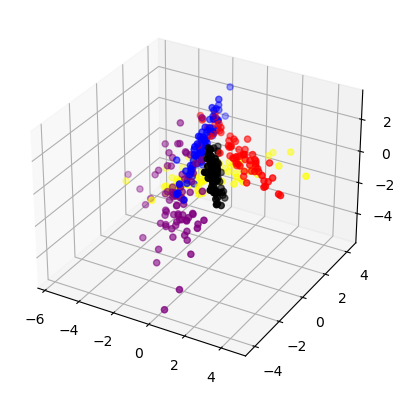

In [67]:
N = 400
colors = ["Blue","Red","Purple","Yellow","Black"]
c = [colors[i] for i in Y_train[:N]]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Сoordinates_train[:N,0], Сoordinates_train[:N,1], Сoordinates_train[:N,2], c=c)
plt.show()

In [120]:
def Gaus(distance,kernel_widht=1.5): # гаусовское ядро
    return np.exp(-((distance**2)/(kernel_widht**2)))
    
def KNeighbors(a, k, Сoordinates, Label, h = 1, probability = False):
    # Сортировка по евклидовому расстоянию
    dtype = [('index', int), ('lable', int), ('distance', float)]
    data = [(i, y, math.dist(a,x)) for i, x, y in zip(np.arange(len(Label)), Сoordinates, Label)]
    data = np.array(data, dtype=dtype)
    data.sort(order=["distance"])
    # Собрать k соседей
    KNei = [[0] for i in range(max(Label)+1)]
    print(KNei)
    for i in data:
        if len(KNei[i['lable']]) < k:
            KNei[i['lable']].append(i['distance'])
        # Остановка
        if sum(len(l) for l in KNei) == k * (max(Label)+1):
            break
    KNei = np.array(KNei)
    if not probability:
        # Вернуть argmax суммы гаусовских ядер от евклидового расстояния деленного на h
        return np.argmax(np.sum(Gaus(KNei/h), axis=1))
    else:
        return np.sum(Gaus(KNei/h), axis=1)

In [ ]:
def Gaus(distance,kernel_widht=1.5): # гаусовское ядро c ядром 1,5
    return np.exp(-((distance**2)/(kernel_widht**2)))

In [122]:
gen_X,gen_Y=make_classification(n_samples=1200, n_features=3, 
                           n_informative=3, n_classes=5, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=20)


In [135]:
# Run many combinations in a grid search manner
# To start out, you need to heuristically define your bounds.
results = [] # we will store our results here.
for k in range(1, 12): # maximum neighbor is 9 since 9:1 train split
    # you can create your own list
    # for w in np.array([0.1, 0.5, 1, 10, 100])
    for w in np.random.randint(5, 100000, 100)/1000:
        
        temp_mae = [] # temporary storage for mean absolute error
        
        # Set kernel_width = w
        def gaussian_kernel(distances):
            kernel_width = w
            weights = np.exp(-(distances**2)/(kernel_width))
            return weights
        
        # We take average of ten bootstrapped model.
        for i in range(0,100):
            # Below is my personal way of setting random state. This makes each run a bootstrapped model.
            X_train, X_test, y_train, y_test = train_test_split(gen_X,
                                                                gen_Y,
                                                                test_size=0.1,
                                                                random_state=int(100*np.random.random()))
            knn = KNeighborsRegressor(n_neighbors=k,weights=gaussian_kernel)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            mean_absolute_error = np.mean(abs(y_pred-y_test))
            temp_mae.append(mean_absolute_error)
        average_over_ten_runs = np.mean(temp_mae)
        results.append([k, w, average_over_ten_runs]) # We store our run result.
        
# You can see that our results are stored in format of [k, w, mean_absolute_error]
results



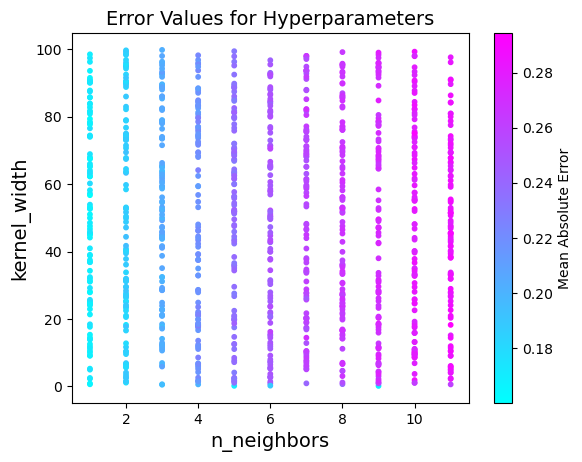

In [ ]:
# For easier access of columns, convert to numpy array 
results = np.array(results)
# Now we visualize.
plt.scatter(results[:,0],results[:,1],c=results[:,2],cmap='cool',s=10)
plt.xlabel('n_neighbors', fontsize=14)
plt.ylabel('kernel_width', fontsize=14)
plt.title('Error Values for Hyperparameters', fontsize=14)
plt.colorbar().set_label('Mean Absolute Error')
#plt.clim(3, 4.0)